## Processing FB imaging data
Note that here we use a max projection across z-planes instead of analyzing 4D imaging data.

In [1]:
from ScanImageTiffReader import ScanImageTiffReader
import json
from matplotlib import pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as ppatch
import numpy as np

#from sys import path
from os.path import sep, exists
from os import mkdir, makedirs, getcwd

import napari
import xarray as xr

import pandas as pd

#for roi generation
import shapely as sp
from shapely.geometry.polygon import LinearRing, Polygon, LineString

%gui qt5
%config Completer.use_jedi = False  #magic to fix autocomplete issue

In [2]:
from fly2p.viz.viz import myAxisTheme, plotShapelyLine, plotEllipse
import fly2p.preproc.imgPreproc as imp
from fly2p.preproc.scanImageUtils import getSIbasicMetadata, getSIMetadict, loadvolume

#### Set paths to data files and plot directory

In [50]:
rootDir = '../../../../data_unityvr'
dataDir = sep.join([rootDir, 'raw/dFB/84C10_x_7f_starvedKS/FB/f01'])
rawTiff = '84C10-x-7f_f01_4-6d_FB-KS_darkFood_00001.tif'
plotDir = sep.join([rootDir, 'plot', sep.join(dataDir.split(sep)[-4:])])
preprocDir = sep.join([rootDir, 'preproc', sep.join(dataDir.split(sep)[-4:])])

print(dataDir)
print(plotDir)

genotype = rawTiff.split('_')[0]
[flyID, age, region] = rawTiff.split('_')[1:4]
condition = rawTiff.split('_')[-2]
trial = 'trial'+rawTiff.split('_')[-1][:-4][-2:]
print(genotype, region, flyID, age, condition, trial)

../../../../data_unityvr/raw/dFB/84C10_x_7f_starvedKS/FB/f01
../../../../data_unityvr/plot/dFB/84C10_x_7f_starvedKS/FB/f01
84C10-x-7f FB-KS f01 4-6d darkFood trial01


In [51]:
# Generate directory where to save plots
saveDir = sep.join([plotDir, condition])
if not exists(saveDir):
    makedirs(saveDir)
print(saveDir)

ppsaveDir = sep.join([preprocDir, condition])
if not exists(ppsaveDir):
    makedirs(ppsaveDir)
print(ppsaveDir)

../../../../data_unityvr/plot/dFB/84C10_x_7f_starvedKS/FB/f01/darkFood
../../../../data_unityvr/preproc/dFB/84C10_x_7f_starvedKS/FB/f01/darkFood


#### Load data and perform motion correction

In [52]:
mytiffreader = ScanImageTiffReader(sep.join([dataDir, rawTiff]))
basicMetadat = getSIbasicMetadata(mytiffreader.metadata())
basicMetadat["CaCh"] = 0 # give channel identity
SImetadict = getSIMetadict(mytiffreader.metadata())
#basicMetadat

SI.VERSION_COMMIT = '4a9264c4fccd21a03258704d0d6489537ad79e6c'
SI.VERSION_MAJOR = '2018b'
SI.VERSION_MINOR = '1'


In [53]:
stack = loadvolume(mytiffreader, basicMetadat, selectCaChan=True)
imgStack = imp.stack2xarray(stack, basicMetadat)

Check if reference image is good: It should not be to biased by transient activity peaks.

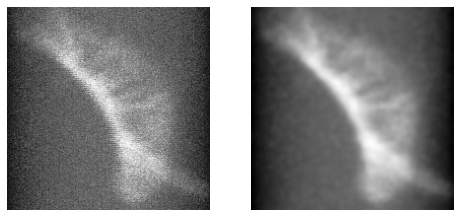

In [54]:
# Set reference image
stackMP = np.max(imgStack, axis=1) # max projection over volume

numRefImg = 600
locRefImg = round(stackMP['volumes [s]'].size/3)

# Generate reference image
refImg = np.mean(stackMP[locRefImg:locRefImg+numRefImg,:,:],axis=0)

from scipy.ndimage.filters import gaussian_filter
refImgFilt = gaussian_filter(refImg, sigma=2)

fig, axs = plt.subplots(1,2,figsize=(8,4))
axs[0].imshow(refImg,cmap='Greys_r', origin='lower'); axs[0].axis('off');
axs[1].imshow(refImgFilt,cmap='Greys_r', origin='lower'); axs[1].axis('off');

In [55]:
stackMPMC, shift = imp.motionCorrection(stackMP, refImg, 20, 2)

#### Compute DFF

In [56]:
## Settings
# settings for Savitzky-Golay filter (default: 3rd order, 7 frames)
order = 3
window = 7

# Currently F_0 is estimated for each pixel on the whole time series (ok, if time series is short)
baseLinePercent = 10
offset = 0.0001

In [57]:
dffStack, stackF0 = imp.computeDFF(stackMPMC, order, window, baseLinePercent, offset)
dffXarray = imp.stack2xarray(dffStack, basicMetadat, data4D = False)

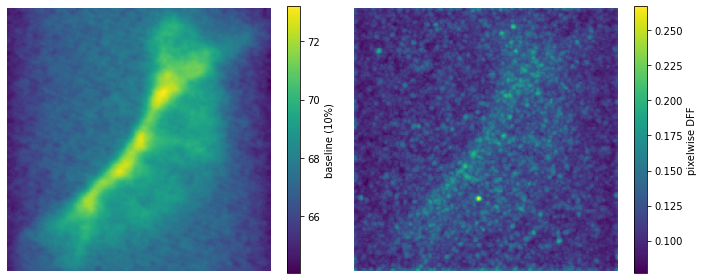

In [58]:
dffMP = np.max(dffStack,axis=0)

fig, ax = plt.subplots(1,2,figsize=(10,4))
cb = ax[0].imshow(stackF0,cmap='viridis',origin='upper')#, vmin=0, vmax=10)
plt.colorbar(cb, ax=ax[0], label='baseline ({}%)'.format(baseLinePercent))
ax[0].axis('off')
cb = ax[1].imshow(dffMP,cmap='viridis',origin='upper')#, vmin=0, vmax=10)
plt.colorbar(cb, ax=ax[1], label='pixelwise DFF')
ax[1].axis('off')
fig.tight_layout()
#viewerdff = napari.view_image(dffStackMC)

### Generate ROIs automatically
We will do this here only for pixels within a manually drawn mask, but it also works fine without a mask.

In [59]:
# you can draw a mask to constraint which pixels will be included in corrleation analysis
viewer = napari.view_image(refImgFilt)

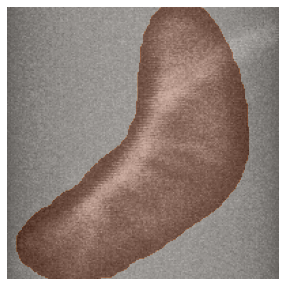

In [60]:
mask = viewer.layers["mask"]
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.imshow(refImg,cmap='Greys_r',origin='upper')
ax.axis('off');
ax.imshow(mask.data, cmap='Oranges', alpha=0.35)
fig.savefig(saveDir+sep+'_'.join(['mask',genotype, region, flyID, age, condition, trial])+'.pdf')

In [61]:
# Settings
from sklearn.cluster import KMeans

nclst = 4

toClust = dffStack[:,mask.data>0]

kmeans = KMeans(n_clusters=nclst)
kmeans.fit(toClust.T)

kmlabs = kmeans.predict(toClust.T)
centroids = kmeans.cluster_centers_

In [62]:
myClstMap = 'tab20b_r'
cNorm  = colors.Normalize(vmin=1, vmax=nclst)
clstCMap = plt.cm.ScalarMappable(norm=cNorm,cmap=myClstMap)

time = dffXarray.coords['volumes [s]'].values

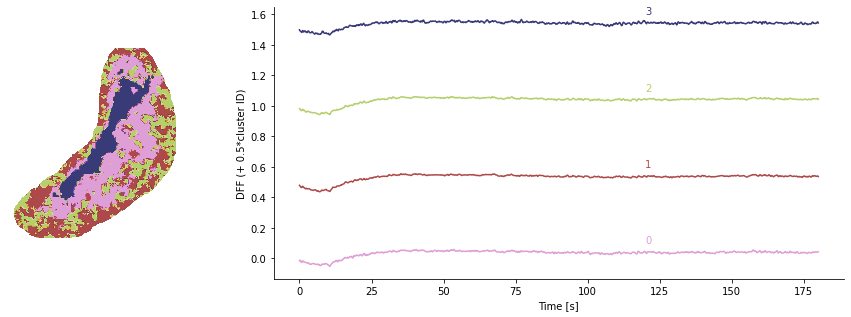

In [63]:
kmlabsImg = np.nan*np.ones(mask.data.shape)

kmlabsImg[mask.data>0] = kmlabs

fig, axs = plt.subplots(1,2,figsize=(15,5), gridspec_kw={'width_ratios':[1,3]})

axs[0].imshow(kmlabsImg,cmap=myClstMap,origin='upper')
axs[0].axis('off')

for i in range(nclst):
    axs[1].plot(time,centroids[i]+i*0.5, color=clstCMap.to_rgba(i+1))
    axs[1].text(120,i*0.5+.1,str(i),color=clstCMap.to_rgba(i+1))
axs[1].set_xlabel('Time [s]')
axs[1].set_ylabel('DFF (+ 0.5*cluster ID)')
myAxisTheme(axs[1])

fig.savefig(saveDir+sep+'_'.join(['ROIcluster_kn{}'.format(nclst),genotype, region, flyID, age, condition, trial])+'.pdf')

#### Generate data object and save to disk

In [64]:
expMetadata = {
    'tiffilename': rawTiff,
    'genotype': genotype,
    'flyid': flyID,
    'trial':trial,
    'roitype': "corr",
    'brainregion': region
}

roiDf = pd.DataFrame(data = centroids.T, 
                     columns = ['roi{}'.format(i) for i in range(nclst)])
roiDf['time [s]']  = time

imgTS_corrroi = imp.imagingTimeseries(
    imgMetadata = basicMetadat, expMetadata = expMetadata,
    refImage = refImg, refStackMC = np.mean(stackMPMC,axis=0), dffStack = np.max(dffXarray,axis=0), 
    roitype = "corr",roiMask = kmlabsImg, roiDFF = roiDf
)

imgTS_corrroi.saveData(ppsaveDir, trial)

'../../../../data_unityvr/preproc/dFB/84C10_x_7f_starvedKS/FB/f01/darkFood/trial01/img'